In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd
import tensorflow

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

In [2]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

In [3]:
### Data Load
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [4]:
att.head() # 앞의 특정 갯수를 보고 싶을 때, 뒤에서 부터 출력은 .tail()사용

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [5]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

Found 202599 validated image filenames.


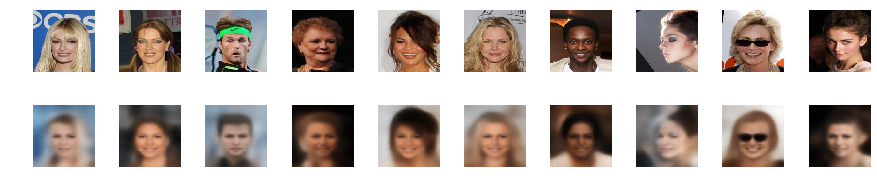

In [6]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show) 
    # flow_from_dataframe : dataframe과 디렉토리의 위치를 전달받아 증강/정규화된 데이터의 배치를 생성

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

잠재 공간의 포인트 분포가 다변수 표준 정규 분포와 비슷한지 확인, 모든 차원을 동시에 보기 힘드므로 개별적으로 분포를 확인
어떤 차원이 표준 정규분포와 다르다면 KL 발산 항이 충분히 영향을 미치지 못한 것이므로 재구성 손실 가중치를 감소시켜야 한다.

Instructions for updating:
Please use Model.predict, which supports generators.
20/20 [==============================] - 0s 16ms/step


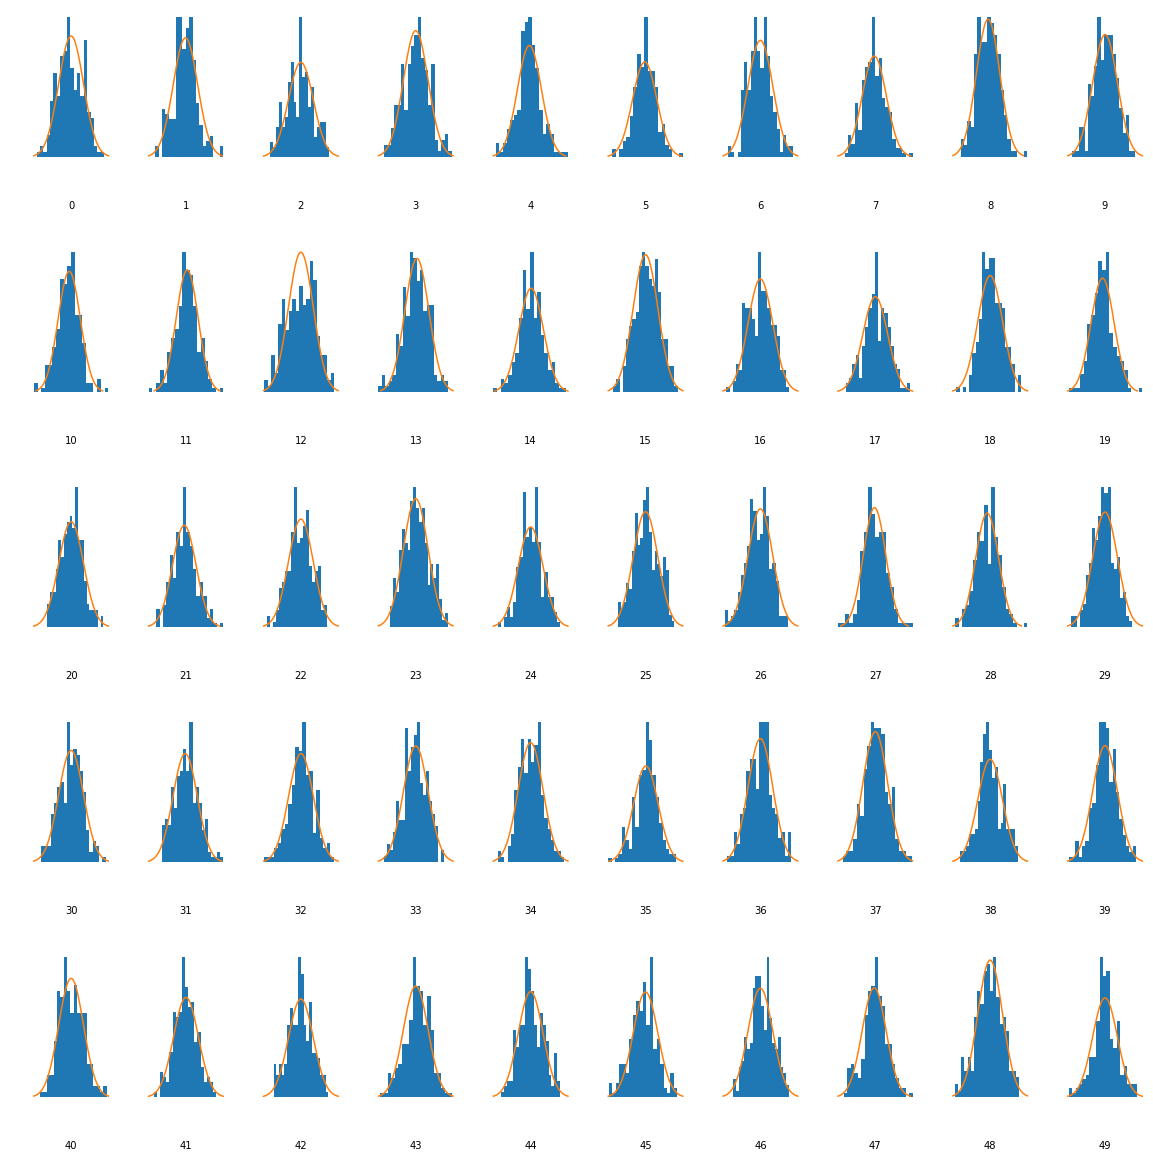

In [7]:
### 잠재 공간의 처음 50개 차원
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

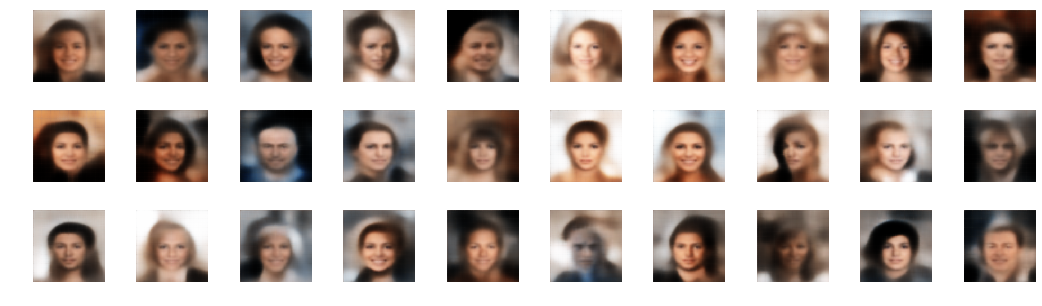

In [8]:
### 잠재 공간에서 새로운 얼굴 생성
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim)) # 표준 정규 분포에서 200개 차원을 가진 30개 포인트 샘플링

reconst = vae.decoder.predict(np.array(znew)) # 디코더에 전달

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:]) # 128 * 128 * 3 크기의 결과 이미지 출력
    ax.axis('off')

plt.show()

In [9]:
print(tensorflow.keras.backend.shape(vae.z_dim))
print((vae.z_dim))

tf.Tensor([], shape=(0,), dtype=int32)
200


In [10]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   

In [11]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1
    
    plt.show()

In [12]:
%%time
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
253    : 1.013    : 0.964    : 1.459    : 1.459
515    : 0.684    : 0.626    : 1.238    : -0.221
785    : 0.35    : 0.339    : 1.142    : -0.097
1048    : 0.272    : 0.262    : 1.063    : -0.078
1308    : 0.205    : 0.213    : 1.019    : -0.044
1572    : 0.148    : 0.168    : 0.973    : -0.045
1848    : 0.126    : 0.142    : 0.966    : -0.008
2092    : 0.114    : 0.122    : 0.964    : -0.002
2358    : 0.102    : 0.105    : 0.978    : 0.014
2619    : 0.091    : 0.106    : 0.969    : -0.009
2866    : 0.075    : 0.099    : 0.971    : 0.001
3110    : 0.076    : 0.082    : 0.949    : -0.021
3391    : 0.069    : 0.064    : 0.951    : 0.002
3653    : 0.062    : 0.072    : 0.942    : -0.009
3899    : 0.065    : 0.061    : 0.942    : 0.0
4182    : 0.062    : 0.058    : 0.947    : 0.005
4431    : 0.049    : 0.059    : 0.941    : -0.006
4689    : 0.053    : 0.057    : 0.933    : -0.007
49

270    : 0.307    : 0.083    : 1.698    : -0.022
300    : 0.272    : 0.071    : 1.657    : -0.041
324    : 0.196    : 0.063    : 1.666    : 0.009
362    : 0.272    : 0.057    : 1.655    : -0.01
397    : 0.218    : 0.055    : 1.613    : -0.042
423    : 0.163    : 0.045    : 1.608    : -0.005
458    : 0.183    : 0.046    : 1.592    : -0.016
501    : 0.187    : 0.042    : 1.567    : -0.025
523    : 0.117    : 0.039    : 1.55    : -0.017
546    : 0.132    : 0.038    : 1.56    : 0.01
586    : 0.148    : 0.035    : 1.565    : 0.005
636    : 0.161    : 0.031    : 1.532    : -0.034
668    : 0.127    : 0.034    : 1.537    : 0.006
697    : 0.103    : 0.03    : 1.541    : 0.004
742    : 0.138    : 0.028    : 1.547    : 0.006
773    : 0.104    : 0.026    : 1.542    : -0.005
803    : 0.101    : 0.026    : 1.536    : -0.006
836    : 0.097    : 0.025    : 1.532    : -0.004
874    : 0.104    : 0.025    : 1.534    : 0.002
904    : 0.089    : 0.023    : 1.529    : -0.005
937    : 0.084    : 0.024    : 1

Attractive Vector


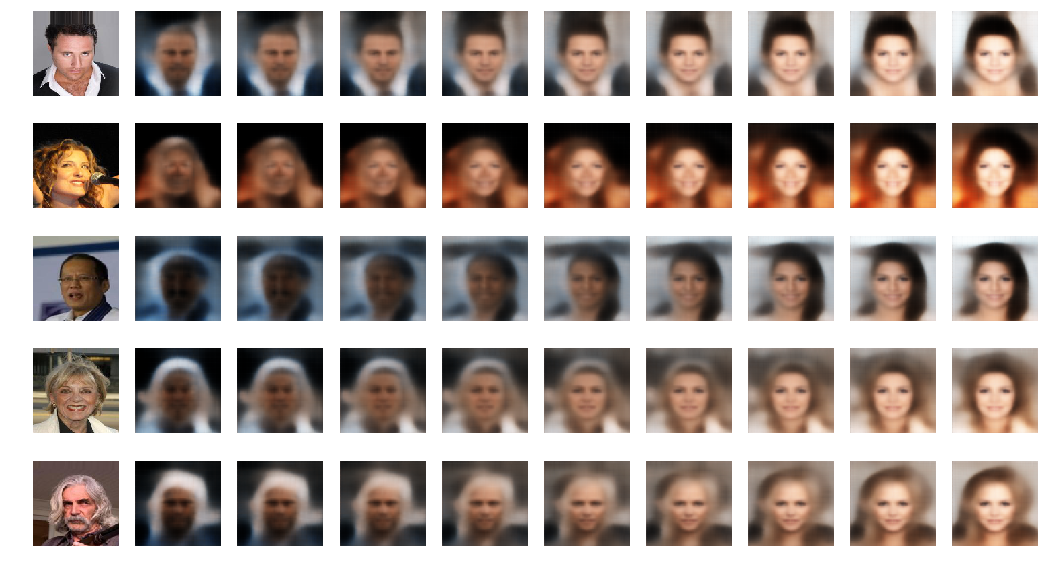

Mouth Open Vector


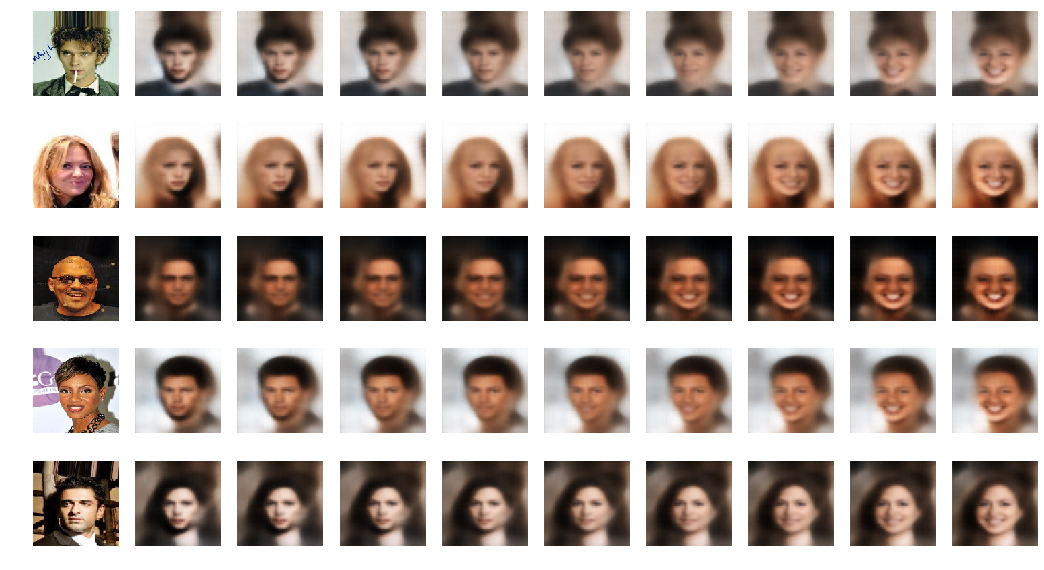

Smiling Vector


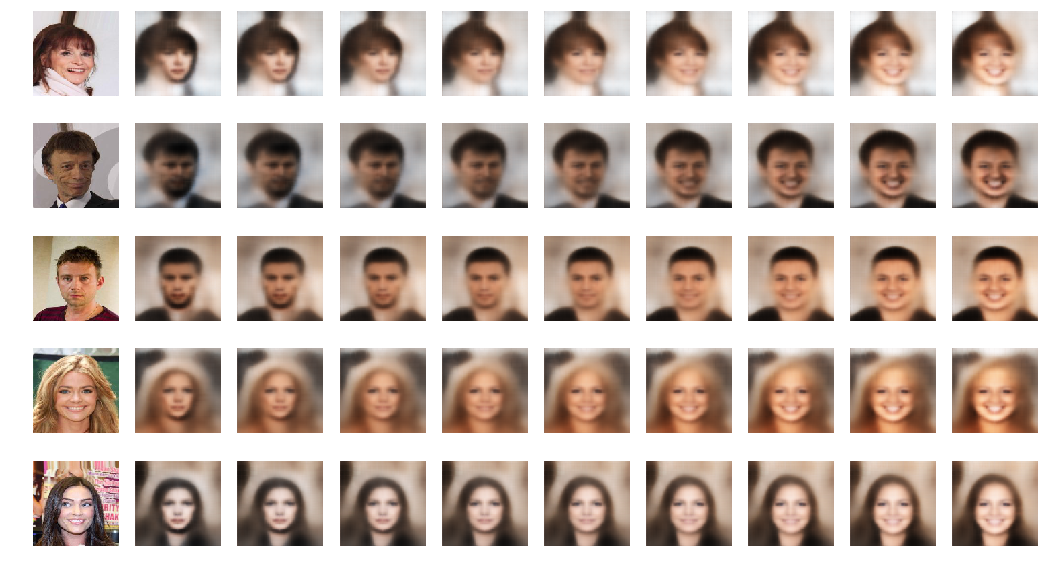

Lipstick Vector


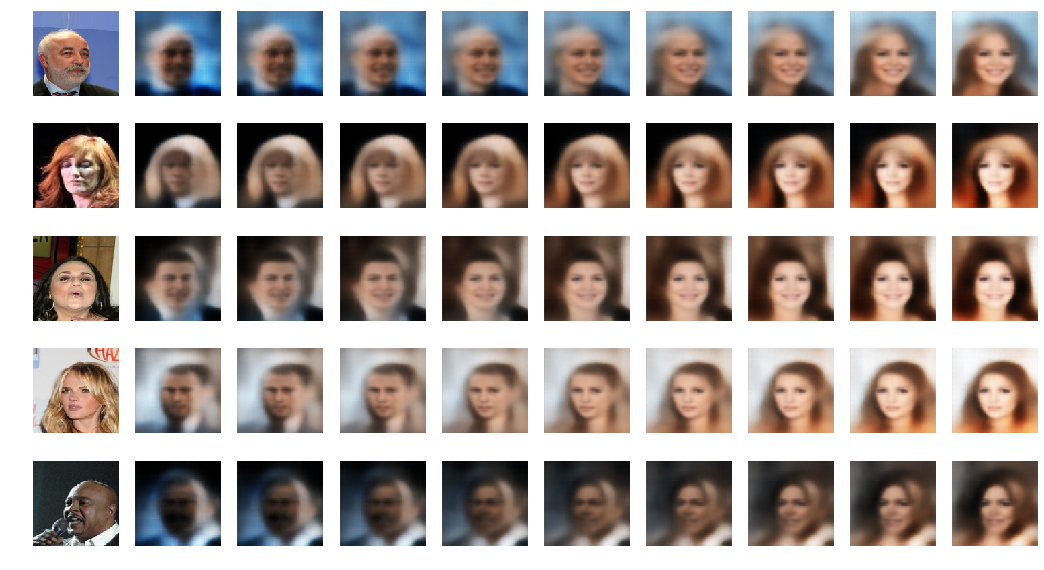

Young Vector


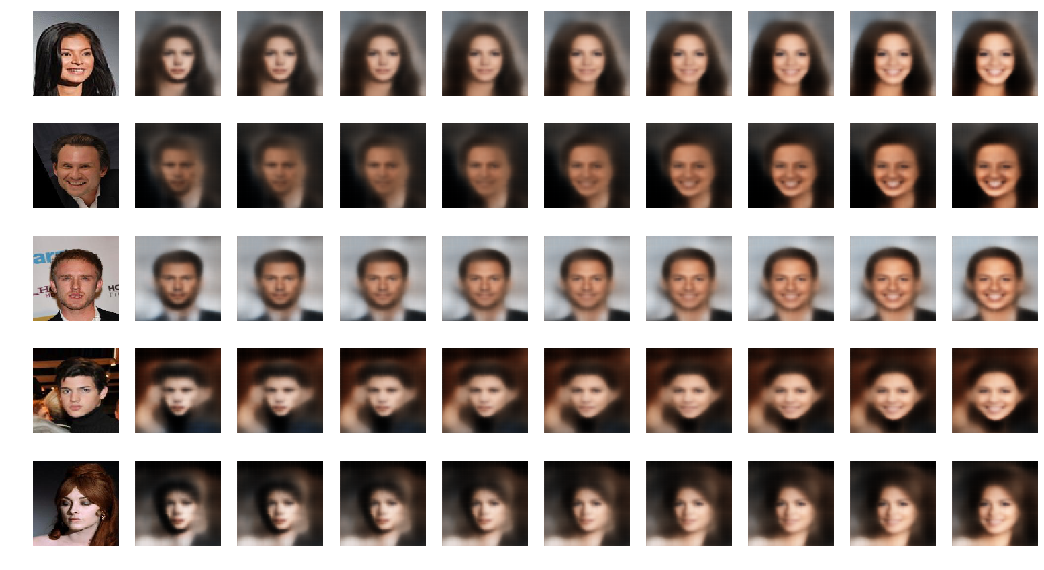

Male Vector


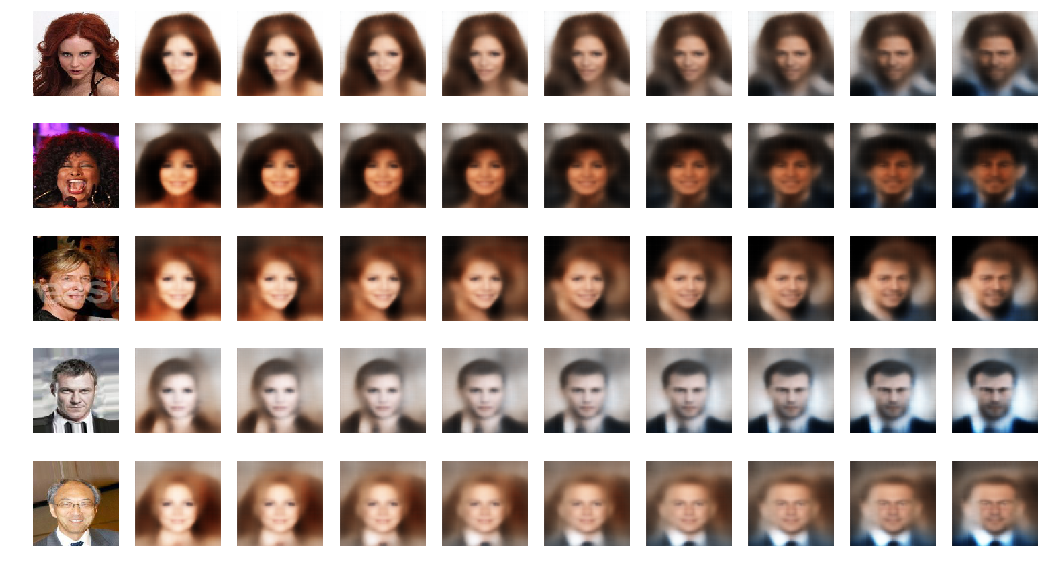

Eyeglasses Vector


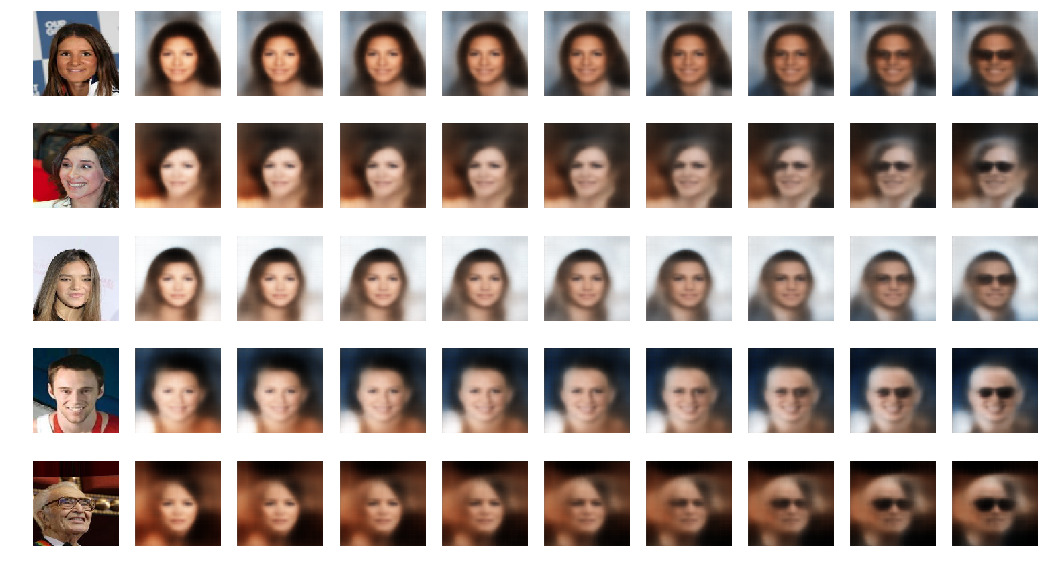

Blond Vector


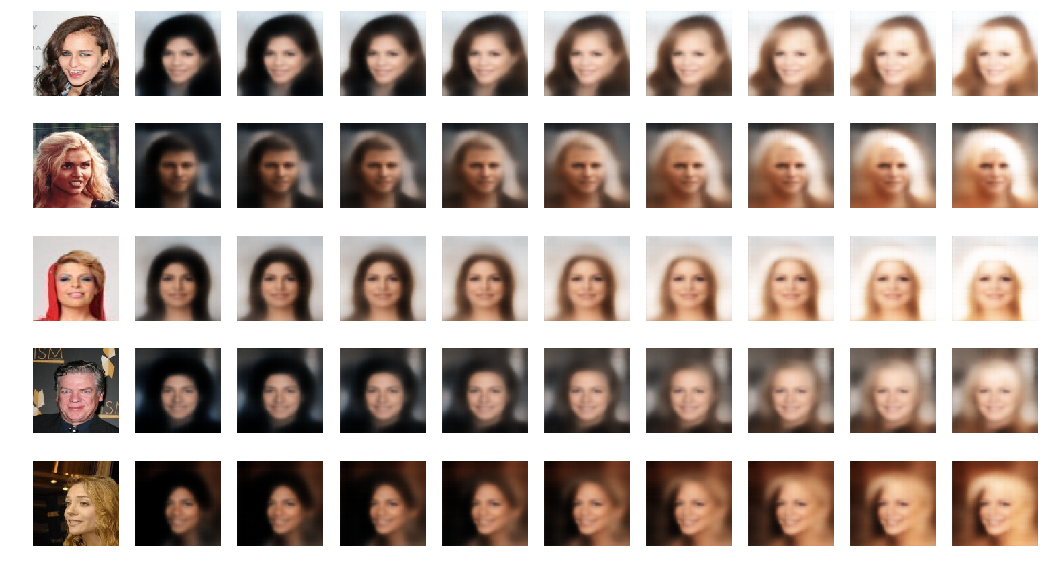

CPU times: user 21.2 s, sys: 2.58 s, total: 23.8 s
Wall time: 18.6 s


In [13]:
%%time
print('Attractive Vector')
add_vector_to_images(attractive_vec)

print('Mouth Open Vector')
add_vector_to_images(mouth_open_vec)

print('Smiling Vector')
add_vector_to_images(smiling_vec)

print('Lipstick Vector')
add_vector_to_images(lipstick_vec)

print('Young Vector')
add_vector_to_images(young_vec)

print('Male Vector')
add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

print('Blond Vector')
add_vector_to_images(blonde_vec)

In [14]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    plt.show()

Found 2 validated image filenames.


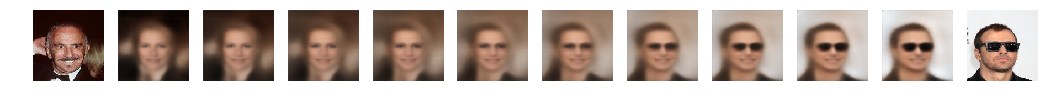

In [15]:
start_image_file = '000209.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


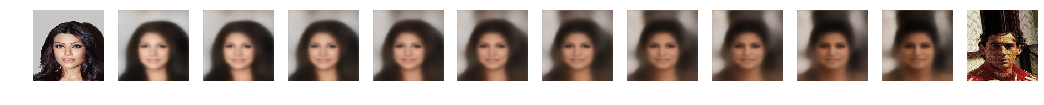

In [16]:
start_image_file = '002112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


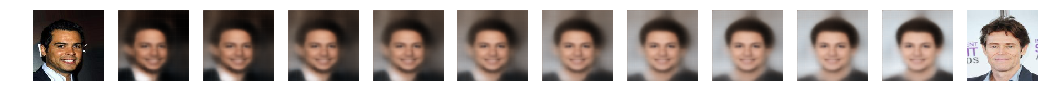

In [17]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)